# Importing necessary libraries

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


# Loading dataset

In [2]:
filepath = ".\KPMG_VI_New_raw_data_update_final.xlsx"

def load_sheet(sheet_name):
    """
    This function uses pandas,
    to read an excel sheet from a workbook,
    and returns a pandas dataframe
    """
    df = pd.read_excel(filepath, sheet_name=sheet_name, header=1)
    return df

## Transactions Data

In [3]:

tran_df = load_sheet("Transactions")
tran_df.shape

(20000, 13)

In [4]:
tran_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [5]:
tran_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

The following issues are evident:
* Missing data in columns:
    online_order, brand, product_line, product_class, product_size, standard_cost, and product_first_sold_date,
* product_first_sold_date column has the wrong data type, date_value instead of datetime    

In [6]:
tran_df['order_status'].value_counts()

Approved     19821
Cancelled      179
Name: order_status, dtype: int64

In [7]:
tran_df['customer_id'].nunique()

3494

In [8]:
tran_df['brand'].value_counts()

Solex             4253
Giant Bicycles    3312
WeareA2B          3295
OHM Cycles        3043
Trek Bicycles     2990
Norco Bicycles    2910
Name: brand, dtype: int64

In [9]:
tran_df['product_line'].value_counts()

Standard    14176
Road         3970
Touring      1234
Mountain      423
Name: product_line, dtype: int64

In [10]:
tran_df['product_class'].value_counts()

medium    13826
high       3013
low        2964
Name: product_class, dtype: int64

In [11]:
tran_df['product_size'].value_counts()

medium    12990
large      3976
small      2837
Name: product_size, dtype: int64

Product specific data should be in its own table

In [12]:
#the online_order column
tran_df['online_order'].value_counts()

1.0    9829
0.0    9811
Name: online_order, dtype: int64

### Exploratory Data Analysis

#### Question
How does online_order relate to order_status?

In [13]:
tran_df['order_status'].value_counts()

Approved     19821
Cancelled      179
Name: order_status, dtype: int64

Both variables in question are categorical.

#### Visualization

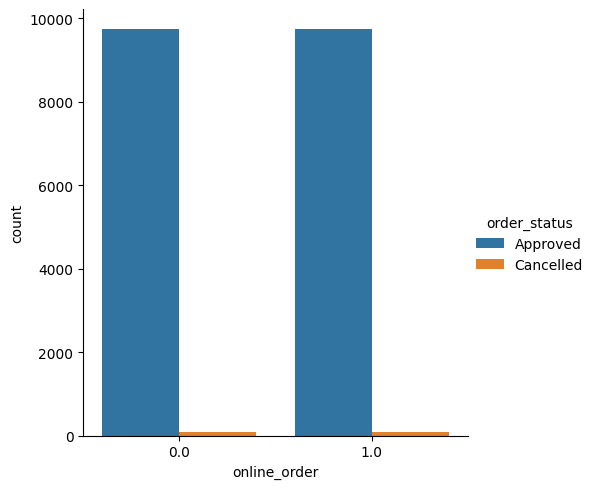

In [14]:
sns.catplot(
    data = tran_df,
    x = 'online_order',
    hue = 'order_status',
    kind = 'count'
);

#### Visualization
An almost equal set of count points for both categories of order_status in online_order column

#### Question
What is the relationship between online_order and product_line?

#### Visualization

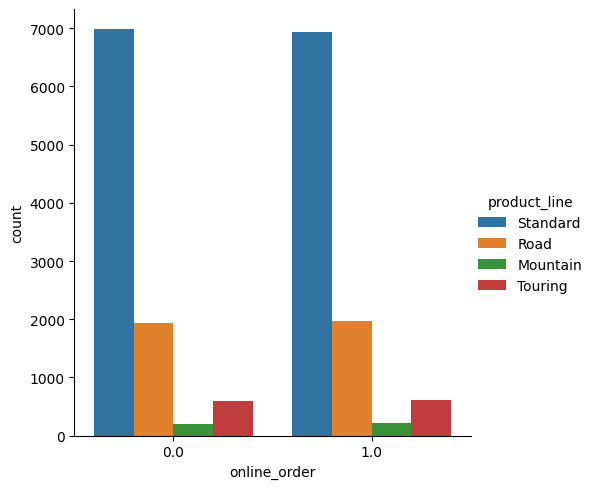

In [15]:
sns.catplot(
    data = tran_df,
    x = "online_order",
    hue = "product_line",
    kind = 'count'
);


#### Observation
There is a uniform distribution of product_line categories across both online_order categories

#### Question
Investigating the relationship between online_order and list_price

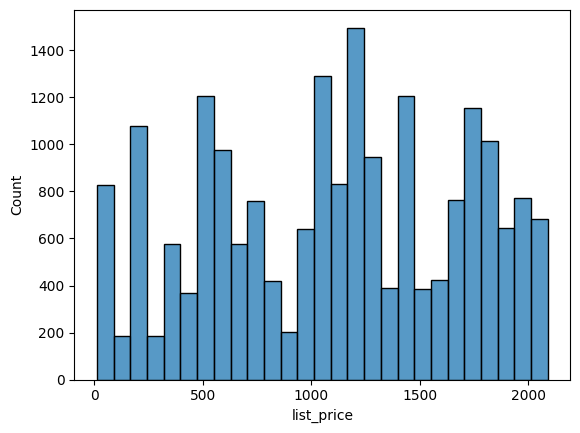

In [16]:
sns.histplot(
    data = tran_df,
    x = "list_price"
);

products list_price has a multi_modal distribution

#### Visualization

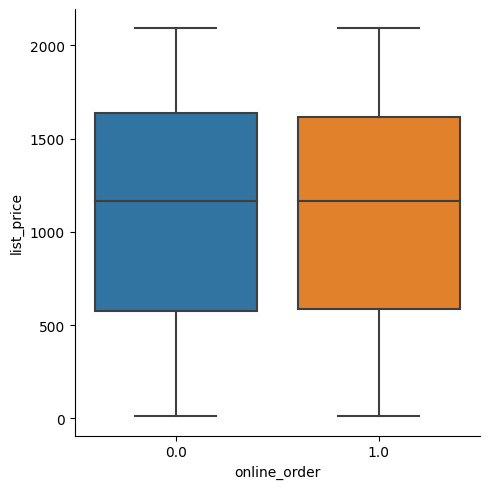

In [17]:
sns.catplot(
    data = tran_df,
    x = "online_order",
    y = "list_price",
    kind = "box"
);

#### Observation
Again, a uniform distribution between the 2 categories

#### Question
What is the relationship between list_price and standard_cost? 

#### Visualization

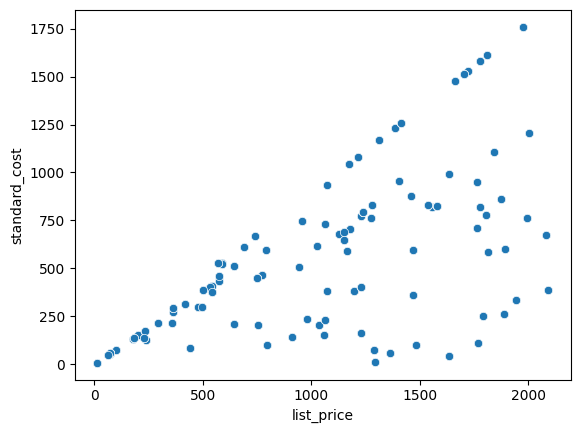

In [18]:
sns.scatterplot(
    data = tran_df,
    x = "list_price",
    y = 'standard_cost'
);

In [19]:
tran_df['standard_cost'].corr(tran_df['list_price'])

0.5515392419631611

#### Observation
There is generally a positive correlation between the features.

## Imputation of Missing Values
Using KNN imputation method to fill missing values

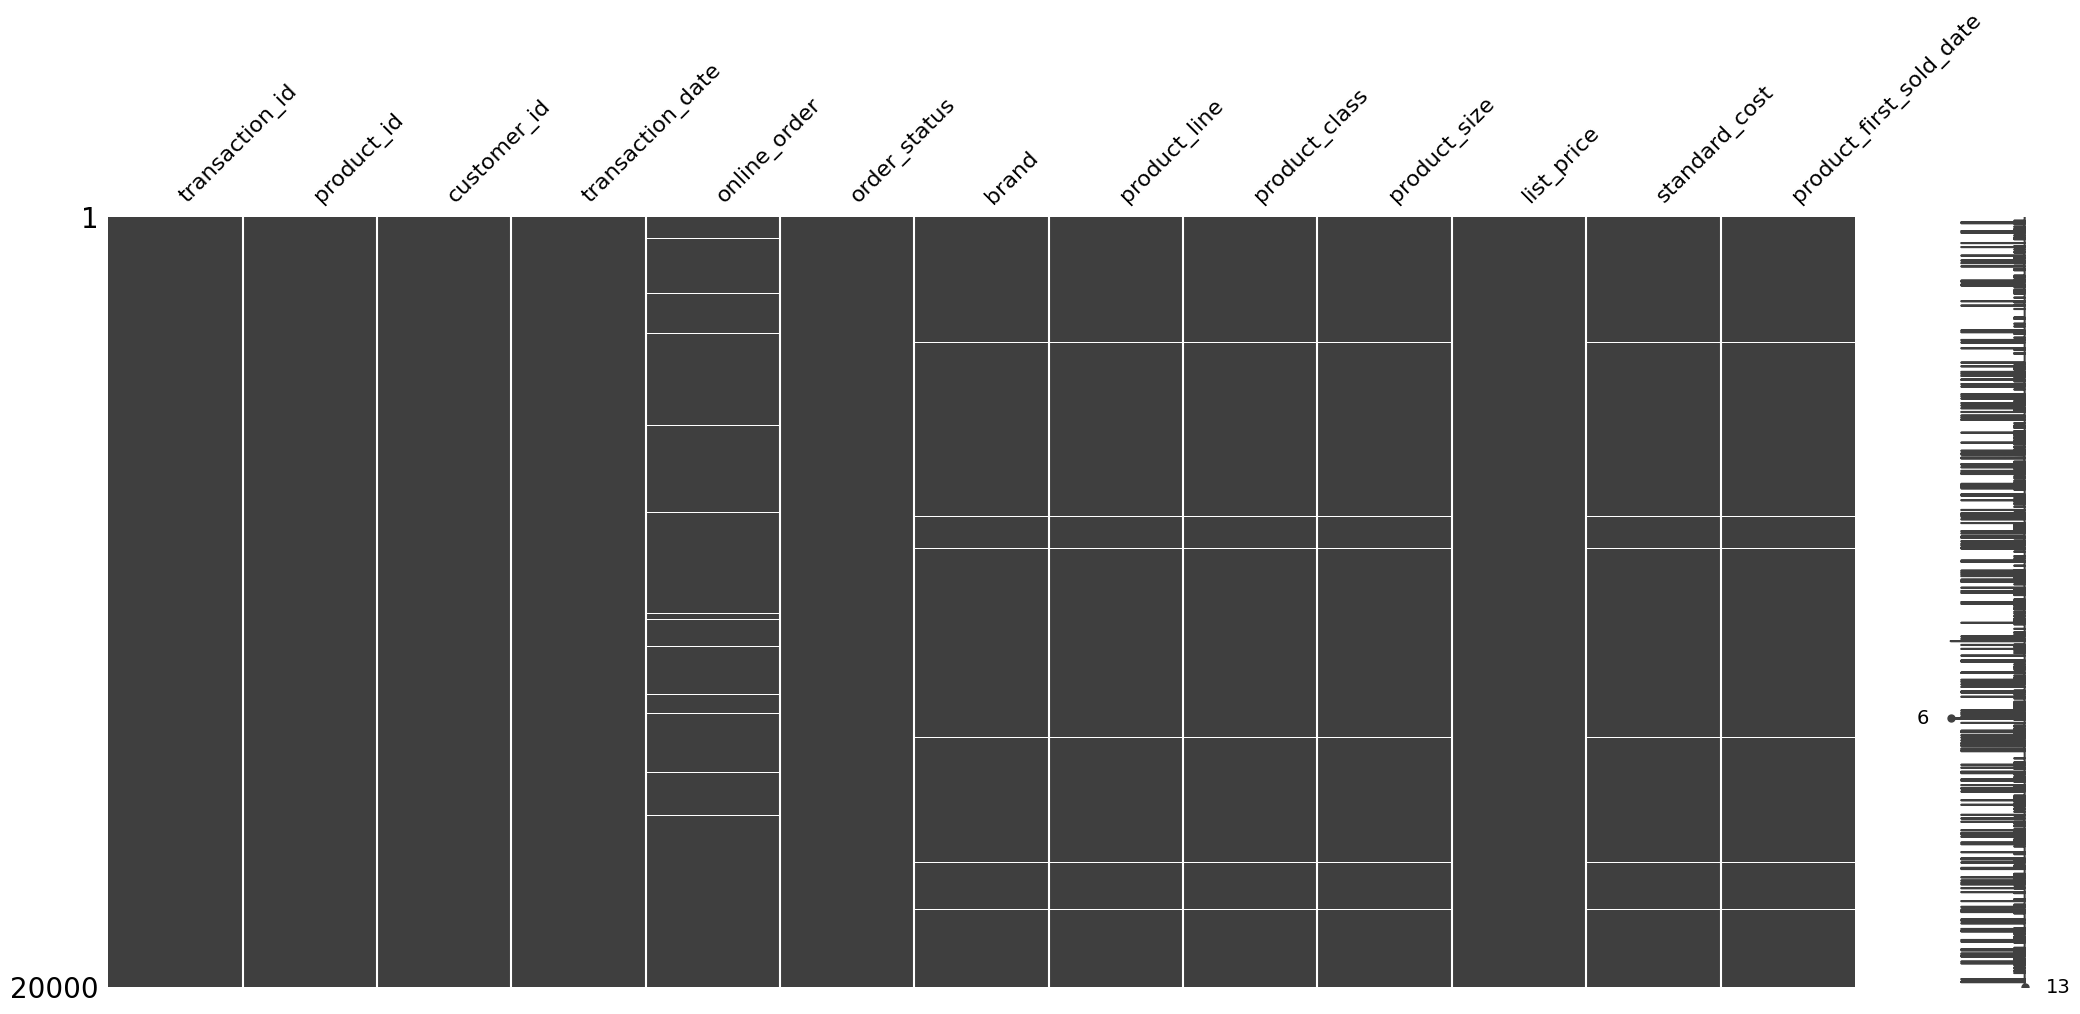

In [20]:
msno.matrix(tran_df);

brand, product_line, product_class, product_size, standard_cost and product_first_sold_date are missing data in similar rows.

In [21]:
#making a copy of the transactions dataframe
tran_copy = tran_df.copy()

In [22]:
# mapping categorical classes into numeric for the KNN algorithm
tran_copy['brand_map'] = tran_copy['brand'].map({'Solex' : 0, 'Giant Bicycles' : 1, 'WeareA2B' : 2, 'OHM Cycles' : 3, 'Trek Bicycles' : 4, 'Norco Bicycles' : 5})
tran_copy['product_line_map'] = tran_copy['product_line'].map({'Standard' : 0, 'Road' : 1, 'Touring' : 2, 'Mountain' : 3})
tran_copy['product_class_map'] = tran_copy['product_class'].map({'medium' : 0, 'high' : 1, 'low' : 2})
tran_copy['product_size_map'] = tran_copy['product_size'].map({'medium' : 0, 'large' : 1, 'small' : 2})

In [23]:
#list of mapped columns to be imputed
prod_list = ['brand_map', 'product_line_map', 'product_class_map', 'product_size_map', 'list_price','standard_cost', 'product_first_sold_date']

In [24]:
tran_copy[prod_list].head()

,brand_map,product_line_map,product_class_map,product_size_map,list_price,standard_cost,product_first_sold_date
0,0.0,0.0,0.0,0.0,71.49,53.62,41245.0
1,4.0,0.0,0.0,1.0,2091.47,388.92,41701.0
2,3.0,0.0,2.0,0.0,1793.43,248.82,36361.0
3,5.0,0.0,0.0,0.0,1198.46,381.10,36145.0
4,1.0,0.0,0.0,1.0,1765.30,709.48,42226.0


In [25]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)

tran_imputed_product = imputer.fit_transform(tran_copy[prod_list])

tran_imputed_product

array([[0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 7.14900e+01,
        5.36200e+01, 4.12450e+04],
       [4.00000e+00, 0.00000e+00, 0.00000e+00, ..., 2.09147e+03,
        3.88920e+02, 4.17010e+04],
       [3.00000e+00, 0.00000e+00, 2.00000e+00, ..., 1.79343e+03,
        2.48820e+02, 3.63610e+04],
       ...,
       [3.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.63690e+03,
        4.47100e+01, 4.04100e+04],
       [3.00000e+00, 0.00000e+00, 1.00000e+00, ..., 2.27880e+02,
        1.36730e+02, 3.82160e+04],
       [4.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.77581e+03,
        1.58047e+03, 3.63340e+04]])

In [26]:
#converting numpy array of imputed results into a dataframe
prod_imputed_df = pd.DataFrame(tran_imputed_product, columns=prod_list)

In [27]:
prod_imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   brand_map                20000 non-null  float64
 1   product_line_map         20000 non-null  float64
 2   product_class_map        20000 non-null  float64
 3   product_size_map         20000 non-null  float64
 4   list_price               20000 non-null  float64
 5   standard_cost            20000 non-null  float64
 6   product_first_sold_date  20000 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


Remapping original categories into the imputed df

In [28]:
prod_imputed_df['brand'] = prod_imputed_df['brand_map'].map({0 : 'Solex', 1 :'Giant Bicycles', 2 : 'WeareA2B', 3 : 'OHM Cycles', 4 : 'Trek Bicycles', 5 : 'Norco Bicycles'})
prod_imputed_df['product_line'] = prod_imputed_df['product_line_map'].map({0 : 'Standard', 1 : 'Road', 2 : 'Touring', 3 : 'Mountain'})
prod_imputed_df['product_class'] = prod_imputed_df['product_class_map'].map({0 : 'medium', 1 : 'high' , 2 : 'low'})
prod_imputed_df['product_size'] = prod_imputed_df['product_size_map'].map({ 0: 'medium', 1 : 'large', 2 : 'small'})

In [29]:
prod_imputed_df = prod_imputed_df.drop(columns=['brand_map', 'product_line_map', 'product_class_map', 'product_size_map'])

In [30]:
prod_imputed_df.head()

,list_price,standard_cost,product_first_sold_date,brand,product_line,product_class,product_size
0,71.49,53.62,41245.0,Solex,Standard,medium,medium
1,2091.47,388.92,41701.0,Trek Bicycles,Standard,medium,large
2,1793.43,248.82,36361.0,OHM Cycles,Standard,low,medium
3,1198.46,381.10,36145.0,Norco Bicycles,Standard,medium,medium
4,1765.30,709.48,42226.0,Giant Bicycles,Standard,medium,large


In [31]:
#adding back complete product columns into the transactions df
tran_copy[['standard_cost', 'brand', 'product_line', 'product_class', 'product_size', 'product_first_sold_date']] = prod_imputed_df[['standard_cost', 'brand', 'product_line', 'product_class', 'product_size', 'product_first_sold_date']]

In [32]:
#dropping off mapping columns
tran_copy = tran_copy.drop(columns=['brand_map', 'product_line_map', 'product_class_map', 'product_size_map'])

Imputing online_order column

In [33]:
order_df = tran_df.copy()

In [34]:
#creating a map for order_status
order_df['order_status_map'] = order_df['order_status'].map({"Approved" : 1, "Cancelled" : 0})

In [35]:
#using order_status and list_price to impute online_order
ord_list = ['order_status_map', 'online_order', 'list_price']
order_imputed_arr = imputer.fit_transform(order_df[ord_list])
order_imputed_df = pd.DataFrame(order_imputed_arr, columns=ord_list)

In [36]:
#adding back complete online_order column into the transactions df
tran_copy['online_order'] = order_imputed_df['online_order']
tran_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             20000 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    20000 non-null  object        
 7   product_line             20000 non-null  object        
 8   product_class            20000 non-null  object        
 9   product_size             20000 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            20000 non-null  float64       
 12  product_first_sold_date  20000 n

Converting product_first_sold_date into datetime format

In [37]:
#converting serial date format to datetime
import xlrd

def convert_date(serial_date):
    """
    This function takes in a date in serial format,
    and converts it into pandas datetime format,
    using xlrd library
    """
    date_time_date = xlrd.xldate_as_datetime(serial_date, 0)
    date_object = date_time_date.date()
    return date_object

In [38]:
#using convert_date function to convert the dates in product_first_sold_date column
tran_copy['product_first_sold_date'] = tran_copy['product_first_sold_date'].apply(convert_date)

In [39]:
tran_copy['product_first_sold_date'].head()

0    2012-12-02
1    2014-03-03
2    1999-07-20
3    1998-12-16
4    2015-08-10
Name: product_first_sold_date, dtype: object

We have dealt with all issues in the transactions sheet, and will save the clean data to a csv file.

In [40]:
#saving df to csv file
#tran_copy.to_csv("transactions_clean.csv", index=False)

## Customer Addresses

In [41]:
add_df = load_sheet("CustomerAddress")
add_df.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


In [42]:
add_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   address             3999 non-null   object
 2   postcode            3999 non-null   int64 
 3   state               3999 non-null   object
 4   country             3999 non-null   object
 5   property_valuation  3999 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 187.6+ KB


No missing data for addresses

In [43]:
add_df.sample(10)

,customer_id,address,postcode,state,country,property_valuation
3347,3352,29863 Waxwing Court,3056,VIC,Australia,5
1787,1792,2 Spohn Court,2750,NSW,Australia,9
1510,1515,87746 Bellgrove Park,2211,NSW,Australia,10
3399,3404,91 Charing Cross Way,2100,NSW,Australia,11
3731,3736,789 Alpine Lane,2390,NSW,Australia,8
3891,3896,3 Shasta Circle,2165,NSW,Australia,8
3691,3696,19 Daystar Alley,2761,NSW,Australia,8
3757,3762,28008 Mesta Lane,2767,NSW,Australia,9
3682,3687,2 Barby Court,2133,NSW,Australia,8
2571,2576,55501 Sugar Street,2548,NSW,Australia,7


Some states are written in full while some are abbreviations

In [44]:
add_df['state'].value_counts()

NSW                2054
VIC                 939
QLD                 838
New South Wales      86
Victoria             82
Name: state, dtype: int64

In [45]:
#replacing full state names with abbreviations
add_df['state'].replace({'New South Wales':'NSW', 'Victoria':'VIC'}, inplace=True)

In [46]:
add_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   address             3999 non-null   object
 2   postcode            3999 non-null   int64 
 3   state               3999 non-null   object
 4   country             3999 non-null   object
 5   property_valuation  3999 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 187.6+ KB


In [47]:
#saving clean addresses to csv
#add_df.to_csv('addresses_clean.csv', index=False)

## Customer Demographic

In [48]:
demo_df = load_sheet("CustomerDemographic")
demo_df.head()

C:\Users\Siba785\AppData\Local\Temp\ipykernel_16504\153692944.py:9: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df = pd.read_excel(filepath, sheet_name=sheet_name, header=1)


,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,default,owns_car,tenure
0,1,Laraine,Medendorp,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,"""'",Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,<script>alert('hi')</script>,Yes,16.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,2018-02-01 00:00:00,Yes,15.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,() { _; } >_[$($())] { touch /tmp/blns.shellsh...,No,7.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,NIL,Yes,8.0


In [49]:
demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          4000 non-null   int64         
 1   first_name                           4000 non-null   object        
 2   last_name                            3875 non-null   object        
 3   gender                               4000 non-null   object        
 4   past_3_years_bike_related_purchases  4000 non-null   int64         
 5   DOB                                  3913 non-null   datetime64[ns]
 6   job_title                            3494 non-null   object        
 7   job_industry_category                3344 non-null   object        
 8   wealth_segment                       4000 non-null   object        
 9   deceased_indicator                   4000 non-null   object        
 10  default     

missing data in columns: last_name, DOB, job_title, job_industry_category, default, and tenure 

column *default* contains some invalid characters, so will drop it.

In [50]:
demo_df.drop(columns=['default'],inplace=True)

In [51]:
demo_df['gender'].value_counts()

Female    2037
Male      1872
U           88
F            1
Femal        1
M            1
Name: gender, dtype: int64

In [52]:
demo_df['gender'].replace({'F':'Female', 'Femal':'Female', 'M':'Male'}, inplace=True)

In [53]:
#lets see the entries with gender as U, if we can map out the proper gender
demo_df.query('gender == "U"').sample(10)

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
450,451,Marlow,Flowerdew,U,37,NaT,Quality Control Specialist,IT,High Net Worth,N,No,NaN
2919,2920,Casar,Ritchley,U,0,NaT,Business Systems Development Analyst,IT,Mass Customer,N,Yes,NaN
891,892,Conroy,Healy,U,22,NaT,Office Assistant II,IT,Mass Customer,N,Yes,NaN
679,680,Gay,Pickersgill,U,22,NaT,NaN,IT,High Net Worth,N,Yes,NaN
2068,2069,Sol,Holdron,U,32,NaT,Software Test Engineer IV,IT,Mass Customer,N,Yes,NaN
3509,3510,Jemima,Izaac,U,48,NaT,Safety Technician II,IT,Affluent Customer,N,Yes,NaN
1917,1918,Devin,Sandeson,U,83,NaT,Staff Accountant II,IT,Affluent Customer,N,No,NaN
3011,3012,Devland,Probart,U,81,NaT,Technical Writer,IT,Mass Customer,N,Yes,NaN
684,685,Booth,Birkin,U,28,NaT,Senior Developer,IT,Mass Customer,N,No,NaN
2340,2341,Caterina,Scedall,U,41,NaT,Web Designer II,IT,Mass Customer,N,Yes,NaN


Will leave those with gender as U as is.

In [54]:
demo_df.isnull().sum()

customer_id                              0
first_name                               0
last_name                              125
gender                                   0
past_3_years_bike_related_purchases      0
DOB                                     87
job_title                              506
job_industry_category                  656
wealth_segment                           0
deceased_indicator                       0
owns_car                                 0
tenure                                  87
dtype: int64

In [55]:
##using DOB to calculate customer age
demo_df['DOB'].dtype

dtype('<M8[ns]')

In [56]:
from datetime import datetime, date
today = date.today()

def age_converter(birth_date):
    born = birth_date.date()
    age = today.year - born.year - ((today.month, today.day) < (born.month, born.day))
    return age

In [57]:
demo_df['Age'] = demo_df['DOB'].apply(age_converter)

In [58]:
demo_df.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,Age
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,69.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,41.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,Yes,15.0,68.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,No,7.0,61.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,Yes,8.0,45.0


In [59]:
demo_df.drop(columns=['DOB'], inplace=True)

In [60]:
demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          4000 non-null   int64  
 1   first_name                           4000 non-null   object 
 2   last_name                            3875 non-null   object 
 3   gender                               4000 non-null   object 
 4   past_3_years_bike_related_purchases  4000 non-null   int64  
 5   job_title                            3494 non-null   object 
 6   job_industry_category                3344 non-null   object 
 7   wealth_segment                       4000 non-null   object 
 8   deceased_indicator                   4000 non-null   object 
 9   owns_car                             4000 non-null   object 
 10  tenure                               3913 non-null   float64
 11  Age                           

Lets explore some relationships

### Exploratory Data Analysis


#### Question
Relationship between tenure and age.

#### Visualization

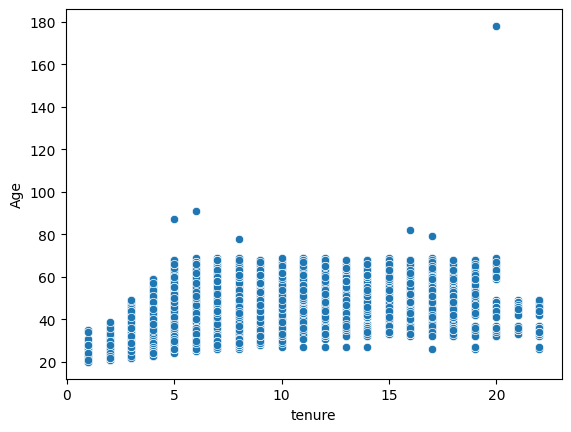

In [61]:
sns.scatterplot(
    data = demo_df,
    x = 'tenure',
    y = 'Age'
);

#### Observation
No concrete relationship between the 2. But there seems to be an outlier in the Age column.

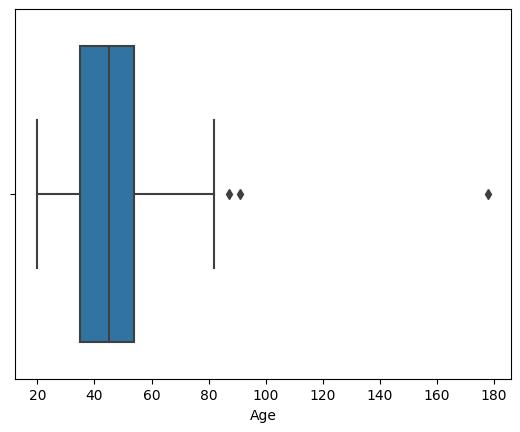

In [62]:
sns.boxplot(
    data = demo_df,
    x = 'Age'
);

There is a customer whose age has been recorded as about 180 years old. Let's see if the person is recorded as still alive or deceased?

In [63]:
demo_df['Age'].max()

178.0

In [64]:
demo_df.query('Age == 178')

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,Age
33,34,Jephthah,Bachmann,U,59,Legal Assistant,IT,Affluent Customer,N,No,20.0,178.0


This person is marked as still alive, and has been very active in the past 3 years with bike_related_purchases. 

#### Question
Let us see the Age distribution within the wealth segments.

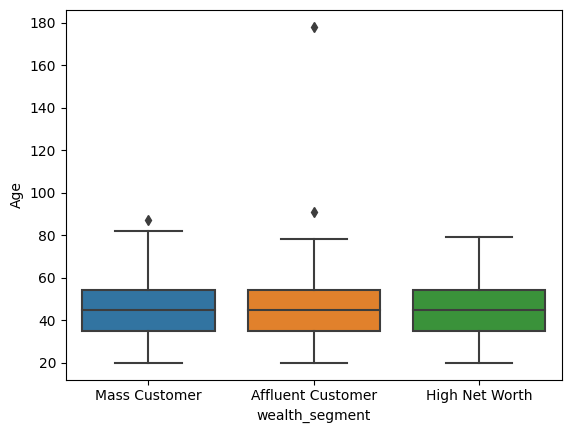

In [65]:
sns.boxplot(
    data = demo_df,
    x = 'wealth_segment',
    y = 'Age'
);

The Age distributions are strikingly similar across all wealth segments. Odd

#### Question
Lets investigate the tenure distribution.

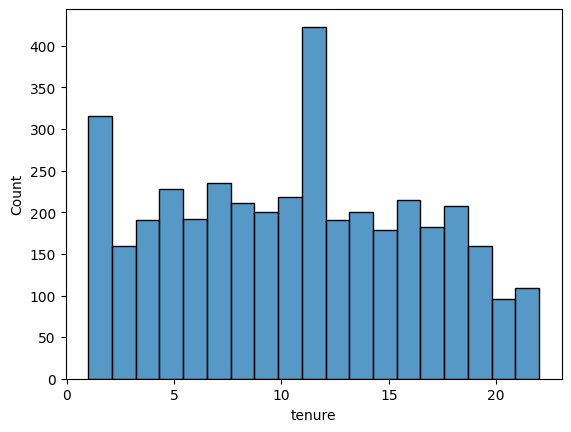

In [66]:
sns.histplot(
    data = demo_df,
    x = "tenure"
);

A bimodal distribution, with most customers having a tenure of 11.

In [67]:
#saving dataframe to csv
#demo_df.to_csv("demographics_clean.csv", index=False)

#### Question
Any relationship between owns_a_car and wealth_segment?

In [68]:
#types of wealth_segment
wealth_segment_classes = ['Affluent Customer', 'High Net Worth', 'Mass Customer']
ws_classes = pd.api.types.CategoricalDtype(ordered=True, categories=wealth_segment_classes)

#converting dtype into an ordered categorical type of wealth segments
demo_df['wealth_segment'] = demo_df['wealth_segment'].astype(ws_classes)

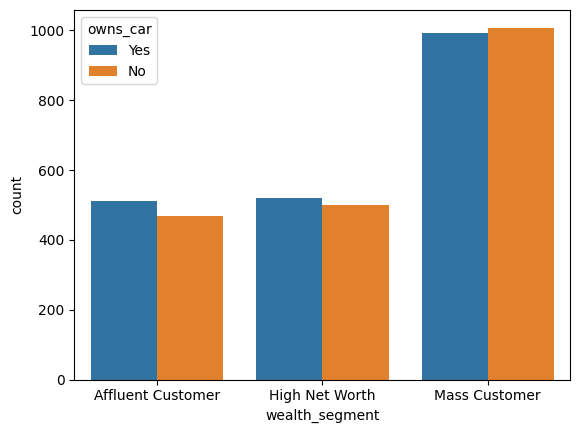

In [69]:
sns.countplot(
    data = demo_df,
    x = 'wealth_segment',
    hue = 'owns_car'
);

Not much distinction in these segments

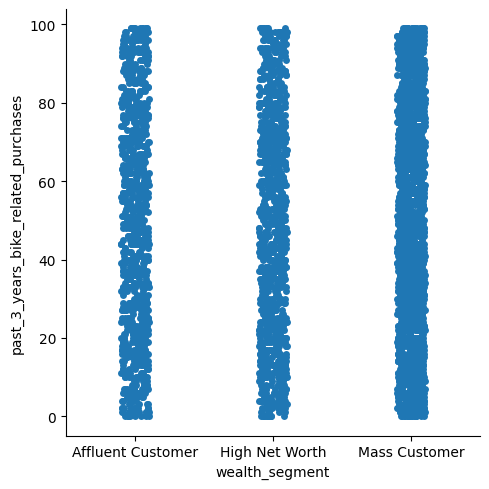

In [70]:
sns.catplot(
    data = demo_df,
    x = 'wealth_segment',
    y = 'past_3_years_bike_related_purchases'
);

In [71]:
#creating a copy of demo_df
demo_copy = demo_df.copy()

In [72]:
#dropping names, and job_title because they do not help that much in analysis
demo_copy.drop(columns=['first_name', 'last_name', 'job_title'], inplace=True)

In [73]:
demo_copy['job_industry_category'].nunique()

9

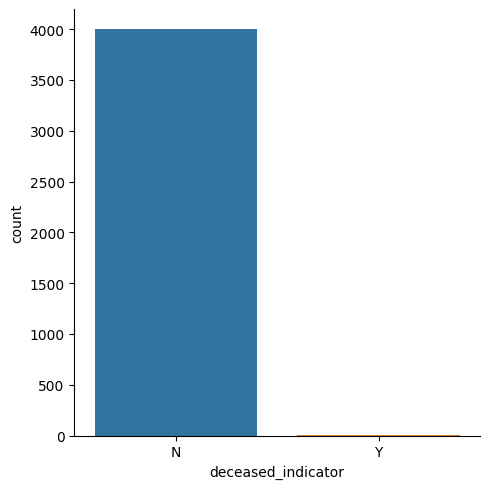

In [74]:
sns.catplot(
    data = demo_copy,
    x = 'deceased_indicator',
    kind='count'
);

We will not get much from the deceased_indicator so we will drop it as well

In [75]:
demo_copy.drop(columns=['deceased_indicator'], inplace=True)

In [76]:
#we will fill in the missing job_industry fields with "Not Specified"
demo_copy['job_industry_category'].fillna("Not Specified", inplace=True)

In [77]:
#we will fill missing values in tenure and Age with the mode
demo_copy['tenure'].fillna(demo_copy['tenure'].mode()[0], inplace=True)
demo_copy['Age'].fillna(demo_copy['Age'].mode()[0], inplace=True)

In [78]:
demo_copy.isnull().sum()

customer_id                            0
gender                                 0
past_3_years_bike_related_purchases    0
job_industry_category                  0
wealth_segment                         0
owns_car                               0
tenure                                 0
Age                                    0
dtype: int64

In [79]:
add_df.isnull().sum()

customer_id           0
address               0
postcode              0
state                 0
country               0
property_valuation    0
dtype: int64

# Merging datasets

In [80]:
#merging demo_df and some columns from add_df
merge_df1 = pd.merge(demo_copy, add_df[['customer_id', 'state', 'property_valuation']], on='customer_id', how='left')

In [81]:
#calculating profit from sale price minus cost price, in transactions,, call this value
tran_copy['value'] = tran_copy['list_price'] - tran_copy['standard_cost']

In [82]:
#grouping total value by customer
cust_value = tran_copy['value'].groupby(tran_copy['customer_id']).sum()

In [83]:
cust_value_df = cust_value.reset_index()

In [84]:
#merging value into merge1 df
combined_df = pd.merge(merge_df1, cust_value_df, on="customer_id", how="inner")

In [85]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   customer_id                          3493 non-null   int64   
 1   gender                               3493 non-null   object  
 2   past_3_years_bike_related_purchases  3493 non-null   int64   
 3   job_industry_category                3493 non-null   object  
 4   wealth_segment                       3493 non-null   category
 5   owns_car                             3493 non-null   object  
 6   tenure                               3493 non-null   float64 
 7   Age                                  3493 non-null   float64 
 8   state                                3489 non-null   object  
 9   property_valuation                   3489 non-null   float64 
 10  value                                3493 non-null   float64 
dtypes: category(1), f

We have 4 missing values in the combined-df's state and property valuation columns. We will fill in missing values using the mode.

In [86]:
combined_df['state'].fillna(combined_df['state'].mode()[0], inplace=True)
combined_df['property_valuation'].fillna(combined_df['property_valuation'].mode()[0], inplace=True)

# Customer Segmentation
This is an unsupervised learning task so we will use Clustering.

## Exploratory Data Analysis

In [87]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   customer_id                          3493 non-null   int64   
 1   gender                               3493 non-null   object  
 2   past_3_years_bike_related_purchases  3493 non-null   int64   
 3   job_industry_category                3493 non-null   object  
 4   wealth_segment                       3493 non-null   category
 5   owns_car                             3493 non-null   object  
 6   tenure                               3493 non-null   float64 
 7   Age                                  3493 non-null   float64 
 8   state                                3493 non-null   object  
 9   property_valuation                   3493 non-null   float64 
 10  value                                3493 non-null   float64 
dtypes: category(1), f

first, we will change gender, job_industry_category, owns_car and state into categorical dtypes

In [88]:
combined_df['property_valuation'].value_counts()

8.0     577
9.0     573
10.0    498
7.0     423
11.0    244
6.0     207
5.0     196
4.0     187
12.0    169
3.0     160
1.0     139
2.0     120
Name: property_valuation, dtype: int64

In [89]:
combined_df['property_valuation'] = combined_df['property_valuation'].astype('str')

In [90]:
categ_list = ['gender', 'job_industry_category', 'owns_car', 'state', 'property_valuation', 'tenure']

def convert_cat(df, cat_list):
    """
    This method takes in a dataframe,
    and a list of categorical fields,
    and changes their datatype,
    into a categorical datatype
    """
    for cat in cat_list:
        df[cat] = df[cat].astype("category")
    return df        

In [91]:
combined_df = convert_cat(combined_df, categ_list)

In [92]:
#updated list of categorical values to add wealth_segment, property_valuation, and numerical values list
cat_cols = ['gender', 'job_industry_category', 'owns_car', 'state',  'wealth_segment']
num_cols = ['past_3_years_bike_related_purchases', 'tenure', 'Age', 'value']

### Numerical features distribution

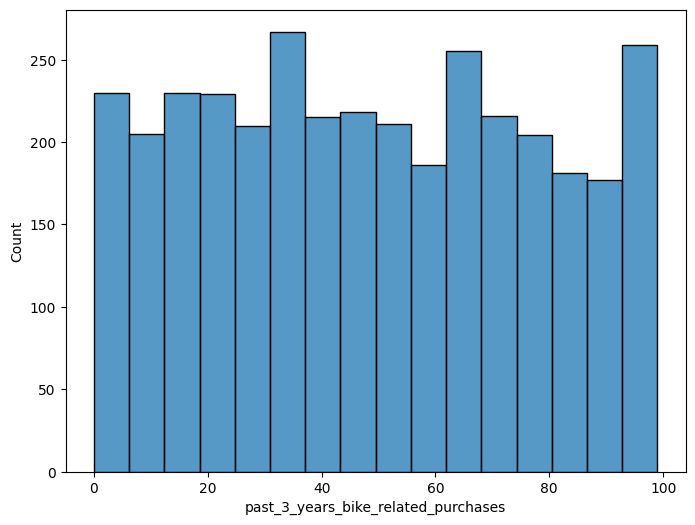

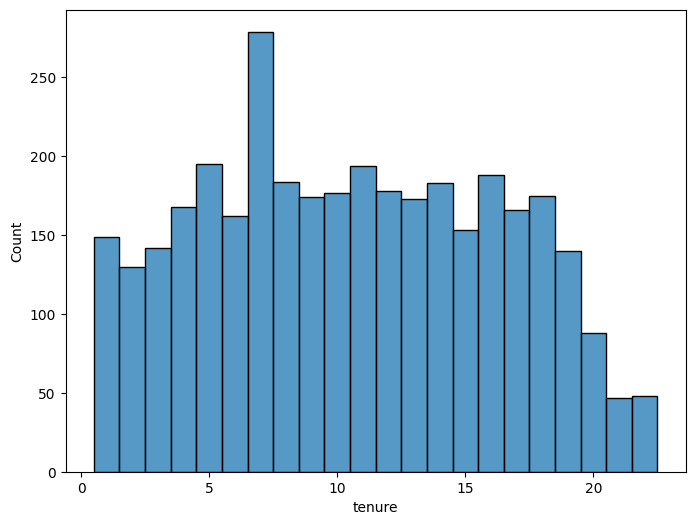

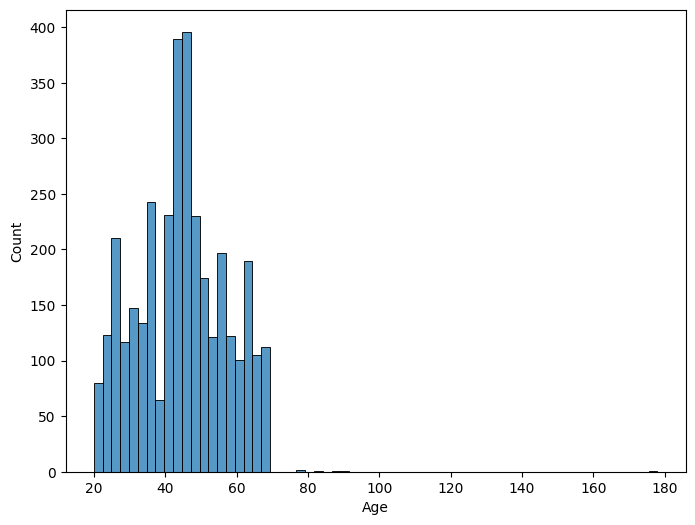

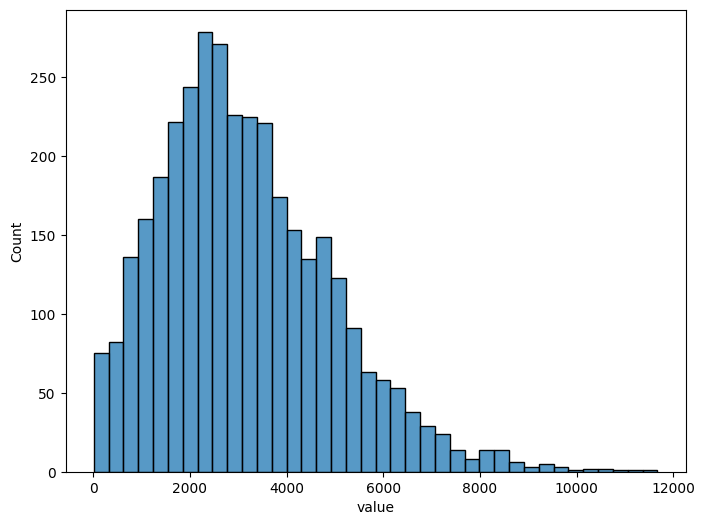

In [93]:
for feature in num_cols:
    plt.figure(figsize=(8,6))
    sns.histplot(
        data = combined_df,
        x = feature
    )

Notable insights:
* tenure has a multi-modal distribution
* Age has a few outliers - we will have to deal with these
* value is left skewed

### Categorical features distribution

<Figure size 800x600 with 0 Axes>

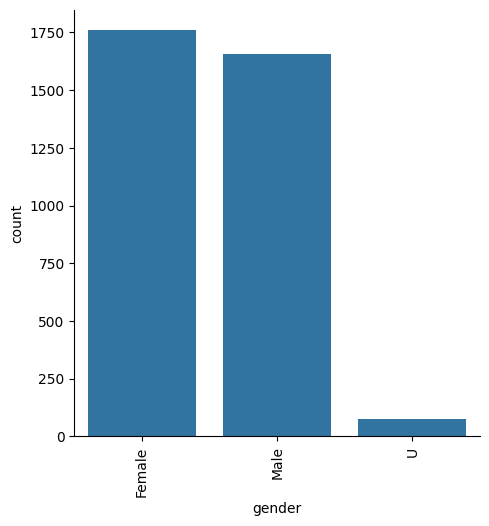

<Figure size 800x600 with 0 Axes>

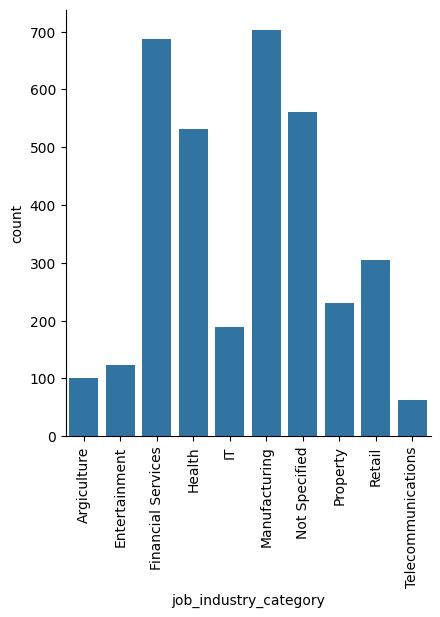

<Figure size 800x600 with 0 Axes>

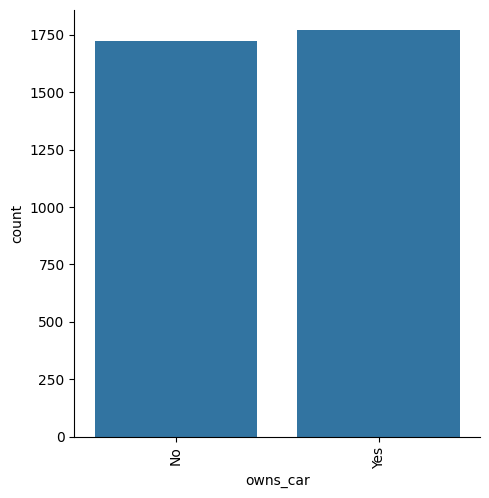

<Figure size 800x600 with 0 Axes>

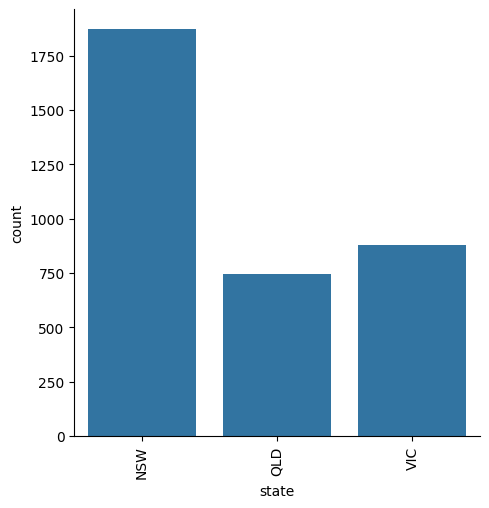

<Figure size 800x600 with 0 Axes>

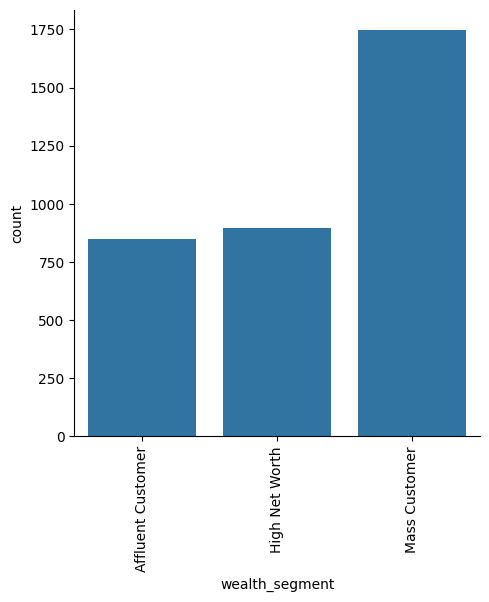

In [94]:
for feature in cat_cols:
    color_palette = sns.color_palette()[0]
    plt.figure(figsize=(8,6))
    sns.catplot(
        data = combined_df,
        x = feature,
        kind = 'count',
        color=color_palette
    )
    plt.xticks(rotation=90)

* Its fairly balanced in Gender and whether customer owns a car or not
* most customers are in the Financial Services and Manufacturing job categories
* New South Wales is the dominant state
* Most customers are in the Mass Customer wealth_segment

### Bivariate Analysis

#### Numeric Features

In [95]:
num_cols

['past_3_years_bike_related_purchases', 'tenure', 'Age', 'value']

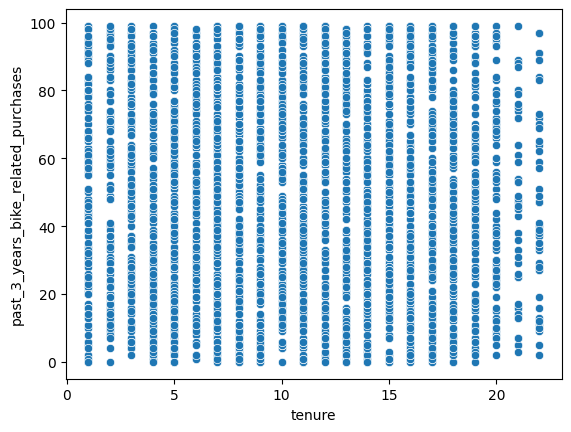

In [96]:
sns.scatterplot(
    data = combined_df,
    x = 'tenure',
    y = 'past_3_years_bike_related_purchases'
);

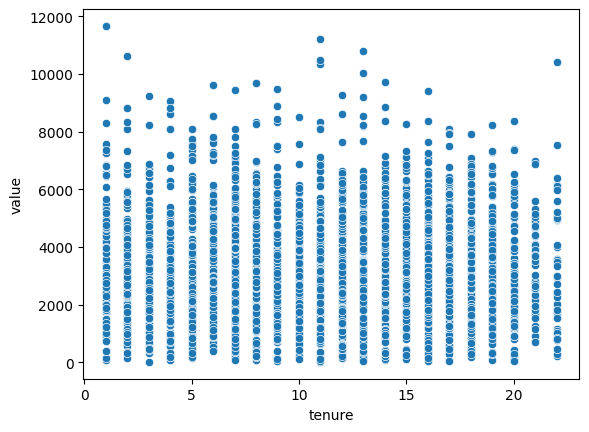

In [97]:
sns.scatterplot(
    data = combined_df,
    x = 'tenure',
    y = 'value'
);

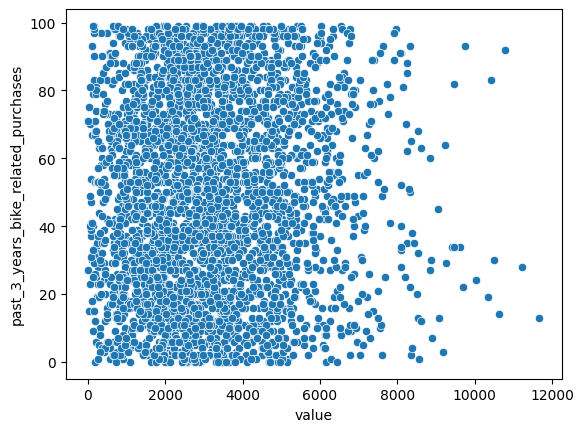

In [98]:
sns.scatterplot(
    data = combined_df,
    x = 'value',
    y = 'past_3_years_bike_related_purchases'
);

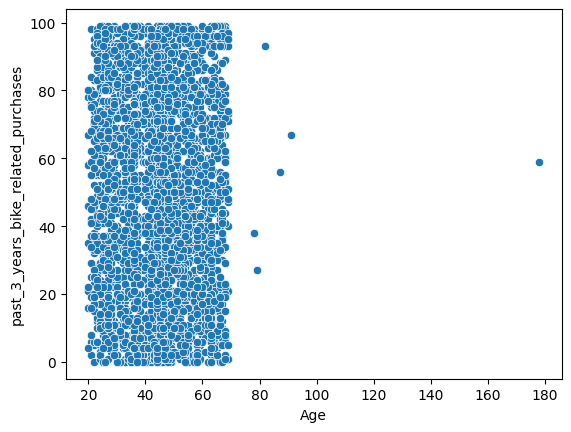

In [99]:
sns.scatterplot(
    data = combined_df,
    x = 'Age',
    y = 'past_3_years_bike_related_purchases'
);

#### Categorical vs Numerical

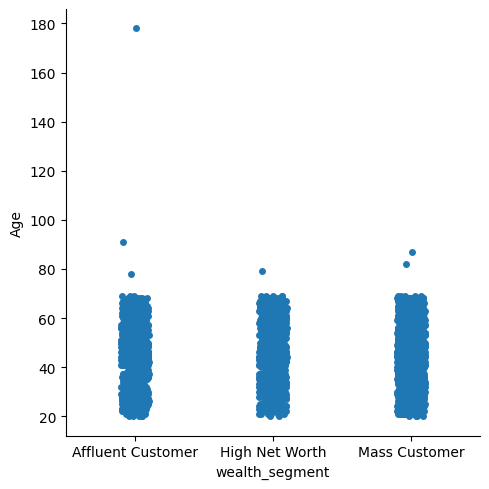

In [100]:
sns.catplot(data=combined_df, x='wealth_segment', y='Age');

## Feature Engineering

Mapping categorical data to numeric values for algorithm

In [101]:
cat_cols

['gender', 'job_industry_category', 'owns_car', 'state', 'wealth_segment']

In [102]:
combined_copy = combined_df.copy()

In [103]:
combined_copy['job_industry_category'].value_counts().index

CategoricalIndex(['Manufacturing', 'Financial Services', 'Not Specified',
                  'Health', 'Retail', 'Property', 'IT', 'Entertainment',
                  'Argiculture', 'Telecommunications'],
                 categories=['Argiculture', 'Entertainment', 'Financial Services', 'Health', 'IT', 'Manufacturing', 'Not Specified', 'Property', ...], ordered=False, dtype='category')

In [104]:
def com_map(x):
    """
    This function takes in a dataframe column row value,
    and maps string categories,
    to numeric ones
    """
    if x == "Manufacturing":
        return 0
    elif x == "Financial Services":
        return 1
    elif x == "Health":
        return 2
    else:
        return 3                        


In [105]:
#keep only 3 categories for 'job_industry_category'
combined_copy['job_industry_category'] = combined_copy["job_industry_category"].map(com_map)

In [106]:
#mapping of gender column
combined_copy['gender'] = combined_copy['gender'].map({'Female' : 0, 'Male' : 1, 'U' : 2})

In [107]:
#mapping of wealth segment column
combined_copy['wealth_segment'] = combined_copy['wealth_segment'].map({'Mass Customer' : 0, 'High Net Worth' : 1, 'Affluent Customer' : 2})

In [108]:
#mapping of owns column
combined_copy['owns_car'] = combined_copy['owns_car'].map({'Yes' : 0, 'No' : 1})

In [109]:
#tenure converted to integer
combined_copy['tenure'] = combined_copy['tenure'].astype("int64")

In [110]:
#mapping of state column
combined_copy['state'] = combined_copy['state'].map({'NSW' : 0, 'VIC' : 1, 'QLD' : 2})

In [111]:
combined_copy.head()

,customer_id,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,Age,state,property_valuation,value
0,1,0,93,2,0,0,11,69.0,0,10.0,3018.09
1,2,1,81,1,0,0,16,41.0,0,10.0,2226.26
2,3,1,61,3,0,0,15,68.0,0,8.0,3362.81
3,4,1,33,3,0,1,7,61.0,2,9.0,220.57
4,5,0,56,3,2,0,8,45.0,0,4.0,2394.94


# Feature Preprocessing

Scaling features

In [114]:
scaler = MinMaxScaler()
combined_transformed = combined_copy.drop(columns=['customer_id'])
X = scaler.fit_transform(combined_transformed)

In [115]:
X[0]

array([0.        , 0.93939394, 0.66666667, 0.        , 0.        ,
       0.47619048, 0.31012658, 0.        , 0.81818182, 0.2576835 ])

# Clustering

## selecting number of clusters
First we will use elbow method, then silhoutte

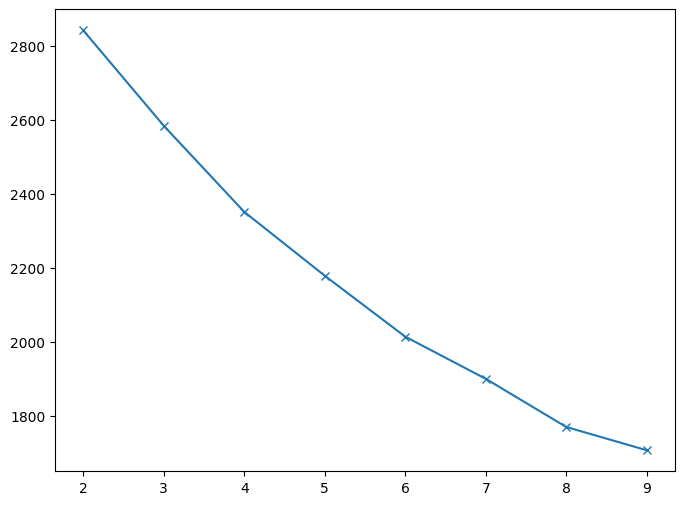

In [120]:
#elbow method
clusters_range = range(2, 10)
inertias = []

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(clusters_range, inertias, marker='x');    

Not really clear, but we can see 4,6,8 clusters.

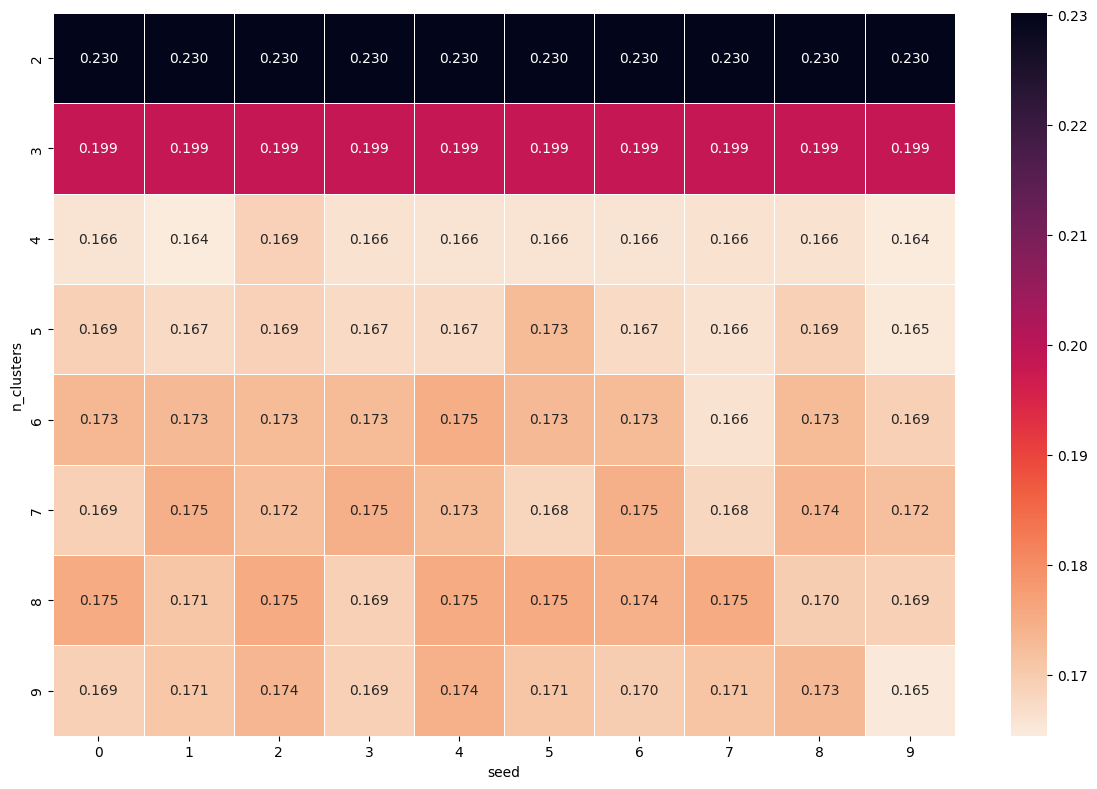

In [121]:
#silhoutte method
from sklearn.metrics import silhouette_samples, silhouette_score

random_range = range(0,10)
results = []

for c in clusters_range:
    for r in random_range:
        clust = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clust.fit_predict(X)
        silhoutte_avg = silhouette_score(X, cluster_labels)
        results.append([c,r,silhoutte_avg])

result = pd.DataFrame(results, columns=['n_clusters', 'seed', 'silhoutte_score'])
pivot_km = pd.pivot_table(result, index='n_clusters', columns='seed', values='silhoutte_score')

plt.figure(figsize=(12,8))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r);
plt.tight_layout()


We will choose n=4 clusters

In [122]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

In [123]:
labels = kmeans.labels_

For visualization of clusters I will create a 3 dimensional dataset using PCA.

# Intepretation and Visualization

In [124]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X)

In [125]:
pca_df = pd.DataFrame(X_pca, columns=['f1', 'f2', 'f3'])

In [126]:
#appending labels to PCA df
pca_df['Labels'] = labels

visualization

In [127]:
import plotly.express as px

fig = px.scatter_3d(pca_df, x='f1', y='f2', z='f3', color=pca_df['Labels'])
fig.show()

The clusters are visible although there are certainly some sub_clusters inside them.

In [129]:
pca_df['Labels'].value_counts()

1    908
3    905
0    865
2    815
Name: Labels, dtype: int64

In [131]:
#appending labels to clean combined df
combined_df['cluster'] = pca_df['Labels']

In [133]:
#saving to csv for analysis in Tableau
combined_df.to_csv("combined_clean.csv", index=False)